In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import fashion_mnist

# Data loading and exploration
We start by loading the dataset. Pixel values are normalized to the range 0..1

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train/255
x_test = x_test/255

Now, let's visualize the first few images to better understand the dataset.

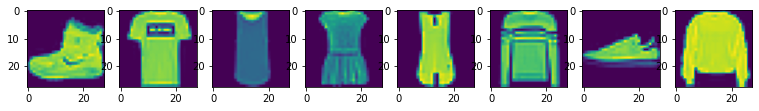

In [5]:
fig, axes = plt.subplots(1, 8, figsize=(13,13))
for i in range(8):
    axes[i].imshow(x_train[i])

By looking at the histogram of class labels, we see that the data is class-balanced. This will make training and evaluation easier.

In [6]:
np.histogram(y_train) # histrogram of class labels

(array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]))

# Training

In the rest of the notebook, I'm going to train three models:
* simple convolutional model,
* simple convolutional model with augmentations,
* mobilenet v2 with augmentations.

The results are summarized in the table:

| model  | test accuracy  | params   |
|---|---|---|
| simple             |   90%   | 269k  |
| simple + augment   |   91%   | 269k  |
| mobilent + augment |   93%   | 2270k  |

**Train/test split**

Normally, a validation set is used to select the best model. To simplify things, we'll abuse the process and selected the best model directly on the test set.

**Optimizer**

We'll use the popular Adam optimizer since it requires less param tunning that other optimizers.

## Simple convolutional model
The first approach is to build a model with two convolutional layers, and dense output.

In [18]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras import Model

inputs = Input(shape=(28,28,1))
x = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(inputs)
x = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)

model_simple = Model(inputs=inputs, outputs=outputs)

model_simple.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_simple.fit(x_train[..., None], y_train, validation_data=(x_test[..., None], y_test), epochs=15)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 8s 141us/sample - loss: 0.3922 - accuracy: 0.8621 - val_loss: 0.3168 - val_accuracy: 0.8887
Epoch 2/15
60000/60000 [==============================] - 8s 139us/sample - loss: 0.2672 - accuracy: 0.9051 - val_loss: 0.2801 - val_accuracy: 0.9007
Epoch 3/15
60000/60000 [==============================] - 8s 138us/sample - loss: 0.2232 - accuracy: 0.9193 - val_loss: 0.2565 - val_accuracy: 0.9095
Epoch 4/15
60000/60000 [==============================] - 8s 138us/sample - loss: 0.1910 - accuracy: 0.9311 - val_loss: 0.2651 - val_accuracy: 0.9071
Epoch 5/15
60000/60000 [==============================] - 8s 138us/sample - loss: 0.1663 - accuracy: 0.9400 - val_loss: 0.2719 - val_accuracy: 0.9111
Epoch 6/15
60000/60000 [==============================] - 8s 138us/sample - loss: 0.1446 - accuracy: 0.9481 - val_loss: 0.2647 - val_accuracy: 0.9099
Epoch 7/15
60000/60000 [==========================

Although the model is very simple, it overfits the data. This is indicated by the fact that the training accuracy is significantly higher than the validation accuracy. 

# Model with augmentation

To tackle overfitting, let's take advantage of augmentation. We'll use horizontal flip as a simple augmentation. This augmentation is applied randomly through ImageDataGenerator. 

We start by visualizing a few images before and after augmentations.

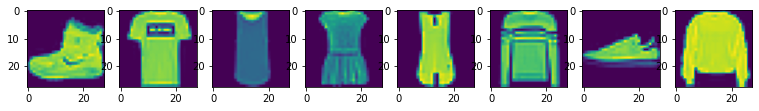

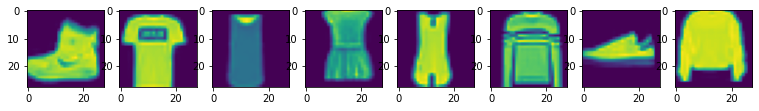

In [20]:
from tensorflow.keras.preprocessing.image import  ImageDataGenerator

datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'constant')

fig, axes = plt.subplots(1, 8, figsize=(13,13))

for i in range(8):
    axes[i].imshow(x_train[i])
    
fig, axes = plt.subplots(1, 8, figsize=(13,13))

flow = datagen.flow(x_train[..., None], y_train, batch_size=1, shuffle=False)
for i in range(8):
    x_trans, _ = next(flow)
    axes[i].imshow(np.squeeze(x_trans))

Now, let's start the training.

In [21]:
from tensorflow.keras.preprocessing.image import  ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True)

inputs = Input(shape=(28,28,1))
x = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(inputs)
x = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)

model_simple = Model(inputs=inputs, outputs=outputs)

model_simple.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_simple.fit_generator(datagen.flow(x_train[..., None], y_train, batch_size=32),
                        validation_data=(x_test[..., None], y_test), epochs=15)

  ...
    to  
  ['...']
Train for 1875 steps, validate on 10000 samples
Epoch 1/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4398 - accuracy: 0.8463 - val_loss: 0.3465 - val_accuracy: 0.8773
Epoch 2/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3041 - accuracy: 0.8924 - val_loss: 0.3318 - val_accuracy: 0.8851
Epoch 3/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2652 - accuracy: 0.9055 - val_loss: 0.2918 - val_accuracy: 0.8967
Epoch 4/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2352 - accuracy: 0.9162 - val_loss: 0.2737 - val_accuracy: 0.9030
Epoch 5/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2145 - accuracy: 0.9224 - val_loss: 0.2725 - val_accuracy: 0.9032
Epoch 6/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1981 - accuracy: 0.9293 - val_loss: 0.2686 - val_accuracy: 0.9062
Epoch 7/15
1875/1875 [==============================] - 9s 5ms/

The results got sligthly better. To get a bigger improvement, we need a model with higher capacity.

# MobileNet V2

To get higher accuracy, we'll use an off-the-shelf image classifier. I choose MobileNet v2, since:
* it has relatively few paramets
* it achives a high accuracy on ImageNet, which is usually a good proxy for other datasets.

**Transfer learning**

We'll use a model pre-trained on ImageNet, since it gives the network good low-level features.

**Input adjustment**

The input to MobileNet are RGB images of size at least 32x32 pixels. To tackle this issue, I upsample images to 56x56 pixels, and stack their channels. This procedure is applied to both train and test images.


In [9]:
import cv2

def upscale_image(img):
    img = cv2.resize(img, (56, 56))
    return np.stack([img, img, img], axis=2)

def upsale_dataset(ds):
    return np.stack([upscale_image(img) for img in ds])

x_train_res = upsale_dataset(x_train)
x_test_res = upsale_dataset(x_test)

In [12]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

datagen = ImageDataGenerator(horizontal_flip=True)

base = MobileNetV2(input_shape=(56,56, 3), include_top=False, weights='imagenet', pooling='avg')

x = base.output
x = tf.keras.layers.Dense(10, activation='softmax')(x)
mobilenet = tf.keras.models.Model(base.inputs, x)


mobilenet.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

mobilenet.fit_generator(datagen.flow(x_train_res, y_train, batch_size=32),
                        validation_data=(x_test_res, y_test), epochs=30)

/home/przemekd/dev_private/fashion-mnist/venv/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


  ...
    to  
  ['...']
Train for 1875 steps, validate on 10000 samples
Epoch 1/30
1875/1875 [==============================] - 66s 35ms/step - loss: 0.4445 - accuracy: 0.8521 - val_loss: 0.9829 - val_accuracy: 0.8103
Epoch 2/30
1875/1875 [==============================] - 62s 33ms/step - loss: 0.2860 - accuracy: 0.9013 - val_loss: 0.4664 - val_accuracy: 0.8819
Epoch 3/30
1875/1875 [==============================] - 63s 34ms/step - loss: 0.2494 - accuracy: 0.9122 - val_loss: 1.3850 - val_accuracy: 0.7691
Epoch 4/30
1875/1875 [==============================] - 62s 33ms/step - loss: 0.2274 - accuracy: 0.9201 - val_loss: 0.7208 - val_accuracy: 0.8322
Epoch 5/30
1875/1875 [==============================] - 63s 34ms/step - loss: 0.2158 - accuracy: 0.9251 - val_loss: 0.4145 - val_accuracy: 0.9019
Epoch 6/30
1875/1875 [==============================] - 63s 34ms/step - loss: 0.1902 - accuracy: 0.9324 - val_loss: 0.3765 - val_accuracy: 0.9044
Epoch 7/30
1875/1875 [=============================

# Possible improvements

The next steps to increase accuracy would be:
* tune hyperparameters,
* try different optimizers,
* try other architectures,
* improve augmentations,
* use model ensemble,
* test-time augmentations.